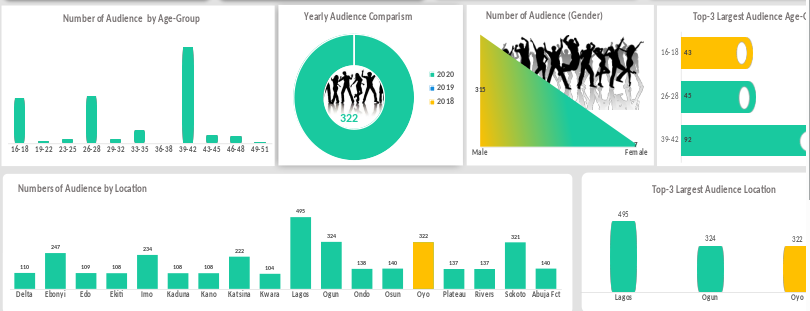

### Ticket Sales Dashboard

Dashboards provide full picture to the stake holders. Sales, Production or IOT enabled home, there has to be easy to read dashboard. We will be looking at the ticket sales data in three years, in multiple locations. 

I had been thinking about how the front end needs the data in JSON format, that is read from the database. The data is queried from the table, and it is sent to the page. Having different tables based on the dashboard, seems to be logically easier

The question is who makes the major part of the data manipulation. Whether the back-end or the front-end app. In order to make the site responsive, it will best to get back-end do all the heavy lifting. 

Based on this thinking, the raw data is sent through different ETL Pipelines and multiple tables are created for the dataset I will be working on this notebook. 

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('ticketSales') \
            .config('spark.jars','/usr/share/java/postgresql-42.2.26.jar') \
            .getOrCreate()
sparksql = spark.sql
sparkread = spark.read
sparkcon = spark.sparkContext

22/12/01 15:55:21 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
22/12/01 15:55:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/01 15:55:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/01 15:55:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
mainDS = pd.read_excel("Tick Sales Dashboard.xlsx",
                       sheet_name="DataSource",
                      header=2)
mainDS.shape

(5092, 12)

In [6]:
mainDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5092 entries, 0 to 5091
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             5092 non-null   int64  
 1   Ticket Types     5092 non-null   object 
 2   Age-Group        5092 non-null   object 
 3   Gender           5092 non-null   object 
 4   Location         5092 non-null   object 
 5   Ticket Price     5092 non-null   int64  
 6   Audience         5092 non-null   int64  
 7   Location-Filter  5092 non-null   bool   
 8   Year-Filter      5092 non-null   bool   
 9   Ticket-Filter    5092 non-null   bool   
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      float64
dtypes: bool(3), float64(2), int64(3), object(4)
memory usage: 373.1+ KB


In [8]:
mainDS.drop(["Unnamed: 10","Unnamed: 11"],axis=1, inplace=True)

,Year,Ticket Types,Age-Group,Gender,Location,Ticket Price,Audience,Location-Filter,Year-Filter,Ticket-Filter
0,2020,VIP,39-41,Male,Delta,100000,1,False,True,True
1,2020,VVIP,39-42,Female,Ebonyi,500000,3,False,True,True


In [11]:
headers = []

for col in mainDS.columns:
    temp = col.replace('-','_')
    temp = temp.replace(' ','_')
    headers.append(temp)
mainDS.columns = headers

In [14]:
mainDS.head(2)

,Year,Ticket_Types,Age_Group,Gender,Location,Ticket_Price,Audience,Location_Filter,Year_Filter,Ticket_Filter
0,2020,VIP,39-41,Male,Delta,100000,1,False,True,True
1,2020,VVIP,39-42,Female,Ebonyi,500000,3,False,True,True


In [13]:
mainDF = spark.createDataFrame(mainDS)
sparksql("CREATE DATABASE IF NOT EXISTS dashboard_wh")
sparksql("USE dashboard_wh")
mainDF.write.saveAsTable("tickets_sale_raw",mode='overwrite')
sparksql("show tables").show()

+------------+----------------+-----------+
|   namespace|       tableName|isTemporary|
+------------+----------------+-----------+
|dashboard_wh|tickets_sale_raw|      false|
+------------+----------------+-----------+



In [16]:
sparksql("""SELECT Age_Group, COUNT(*) as groupCount 
             FROM tickets_sale_raw
             GROUP BY Age_Group""").show()

+---------+----------+
|Age_Group|groupCount|
+---------+----------+
|    36-38|       429|
|    43-45|       452|
|    39-42|       519|
|    49-53|       234|
|    23-25|       380|
|    29-32|       404|
|    19-22|       379|
|    39-41|        96|
|    33-35|       467|
|    49-51|       467|
|    16-18|       338|
|    26-28|       382|
|    46-48|       505|
|    49-52|        15|
|    33-34|        25|
+---------+----------+



In [17]:
sparksql("""SELECT Year, COUNT(*) as yearCount 
             FROM tickets_sale_raw
             GROUP BY Year""").show()

+----+---------+
|Year|yearCount|
+----+---------+
|2020|     2422|
|2018|     1351|
|2019|     1319|
+----+---------+



In [21]:
sparksql("""SELECT Location, Year,COUNT(*) as locationCount 
             FROM tickets_sale_raw
             GROUP BY Location, Year
             ORDER BY COUNT(*) DESC""").show()

+---------+----+-------------+
| Location|Year|locationCount|
+---------+----+-------------+
|    Lagos|2019|         1313|
|    Lagos|2018|         1273|
|    Lagos|2020|          353|
|     Ondo|2020|          138|
|Abuja Fct|2020|          138|
|     Osun|2020|          138|
|     Ogun|2020|          138|
|      Oyo|2020|          138|
|  Plateau|2020|          137|
|   Sokoto|2020|          137|
|   Rivers|2020|          137|
|    Delta|2020|          110|
|   Ebonyi|2020|          109|
|      Edo|2020|          109|
|    Ekiti|2020|          108|
|     Kano|2020|          108|
|      Imo|2020|          108|
|   Kaduna|2020|          108|
|  Katsina|2020|          104|
|    Kwara|2020|          104|
+---------+----+-------------+
only showing top 20 rows



In [22]:
sparksql("""SELECT Gender, Ticket_Types,COUNT(*) as bivarCount 
             FROM tickets_sale_raw
             GROUP BY Gender, Ticket_Types
             ORDER BY COUNT(*) DESC""").show()

+------+------------+----------+
|Gender|Ticket_Types|bivarCount|
+------+------------+----------+
|  Male|     Regular|      3155|
|  Male|         VIP|      1002|
|Female|     Regular|       483|
|  Male|        VVIP|       228|
|Female|         VIP|       159|
|Female|        VVIP|        39|
|  Male|         Vip|        26|
+------+------------+----------+



In [23]:
sparksql("""SELECT Year, Ticket_Types,COUNT(*) as bivarCount 
             FROM tickets_sale_raw
             GROUP BY Year, Ticket_Types
             ORDER BY COUNT(*) DESC""").show()

+----+------------+----------+
|Year|Ticket_Types|bivarCount|
+----+------------+----------+
|2020|     Regular|      1378|
|2018|     Regular|      1307|
|2019|     Regular|       953|
|2020|         VIP|       824|
|2019|         VIP|       337|
|2020|        VVIP|       220|
|2019|        VVIP|        29|
|2018|         Vip|        26|
|2018|        VVIP|        18|
+----+------------+----------+

